# Mike IMC Pipeline v2.1 - 4th May 2023

**Update** - Just a few bug fixes

#### <font color='blue'>This is a work in progress, and should be treated as such. Expect errors and issues! The start should hopefully be fairly 'one size fits all', but as it progresses it gets more and more complex, and will require an increasing knowledge of Python or more customisation to run: </font>

### <font color='green'>Green</font> - Should run with only minor or no changes at all
### <font color='orange'>Orange</font> - Requires a fair amount of customisation, and usually adding in external files (e.g. images or extra .csv files)

### <font color='purple'>Purple</font> - Optional steps that don't need to be run

Developed by Michael Haley (michael.haley@manchester.ac.uk), **please do not share publicly!!**


## <font color='blue'>Before starting...</font>
This guide assumes you have already segmented your data, likely using the Bodenmiller pipeline, but really any pipeline which produces a 'cell table' will work nicely. A really good explanation on the overall IMC analyis strategy can be found here: https://bodenmillergroup.github.io/IMCDataAnalysis/

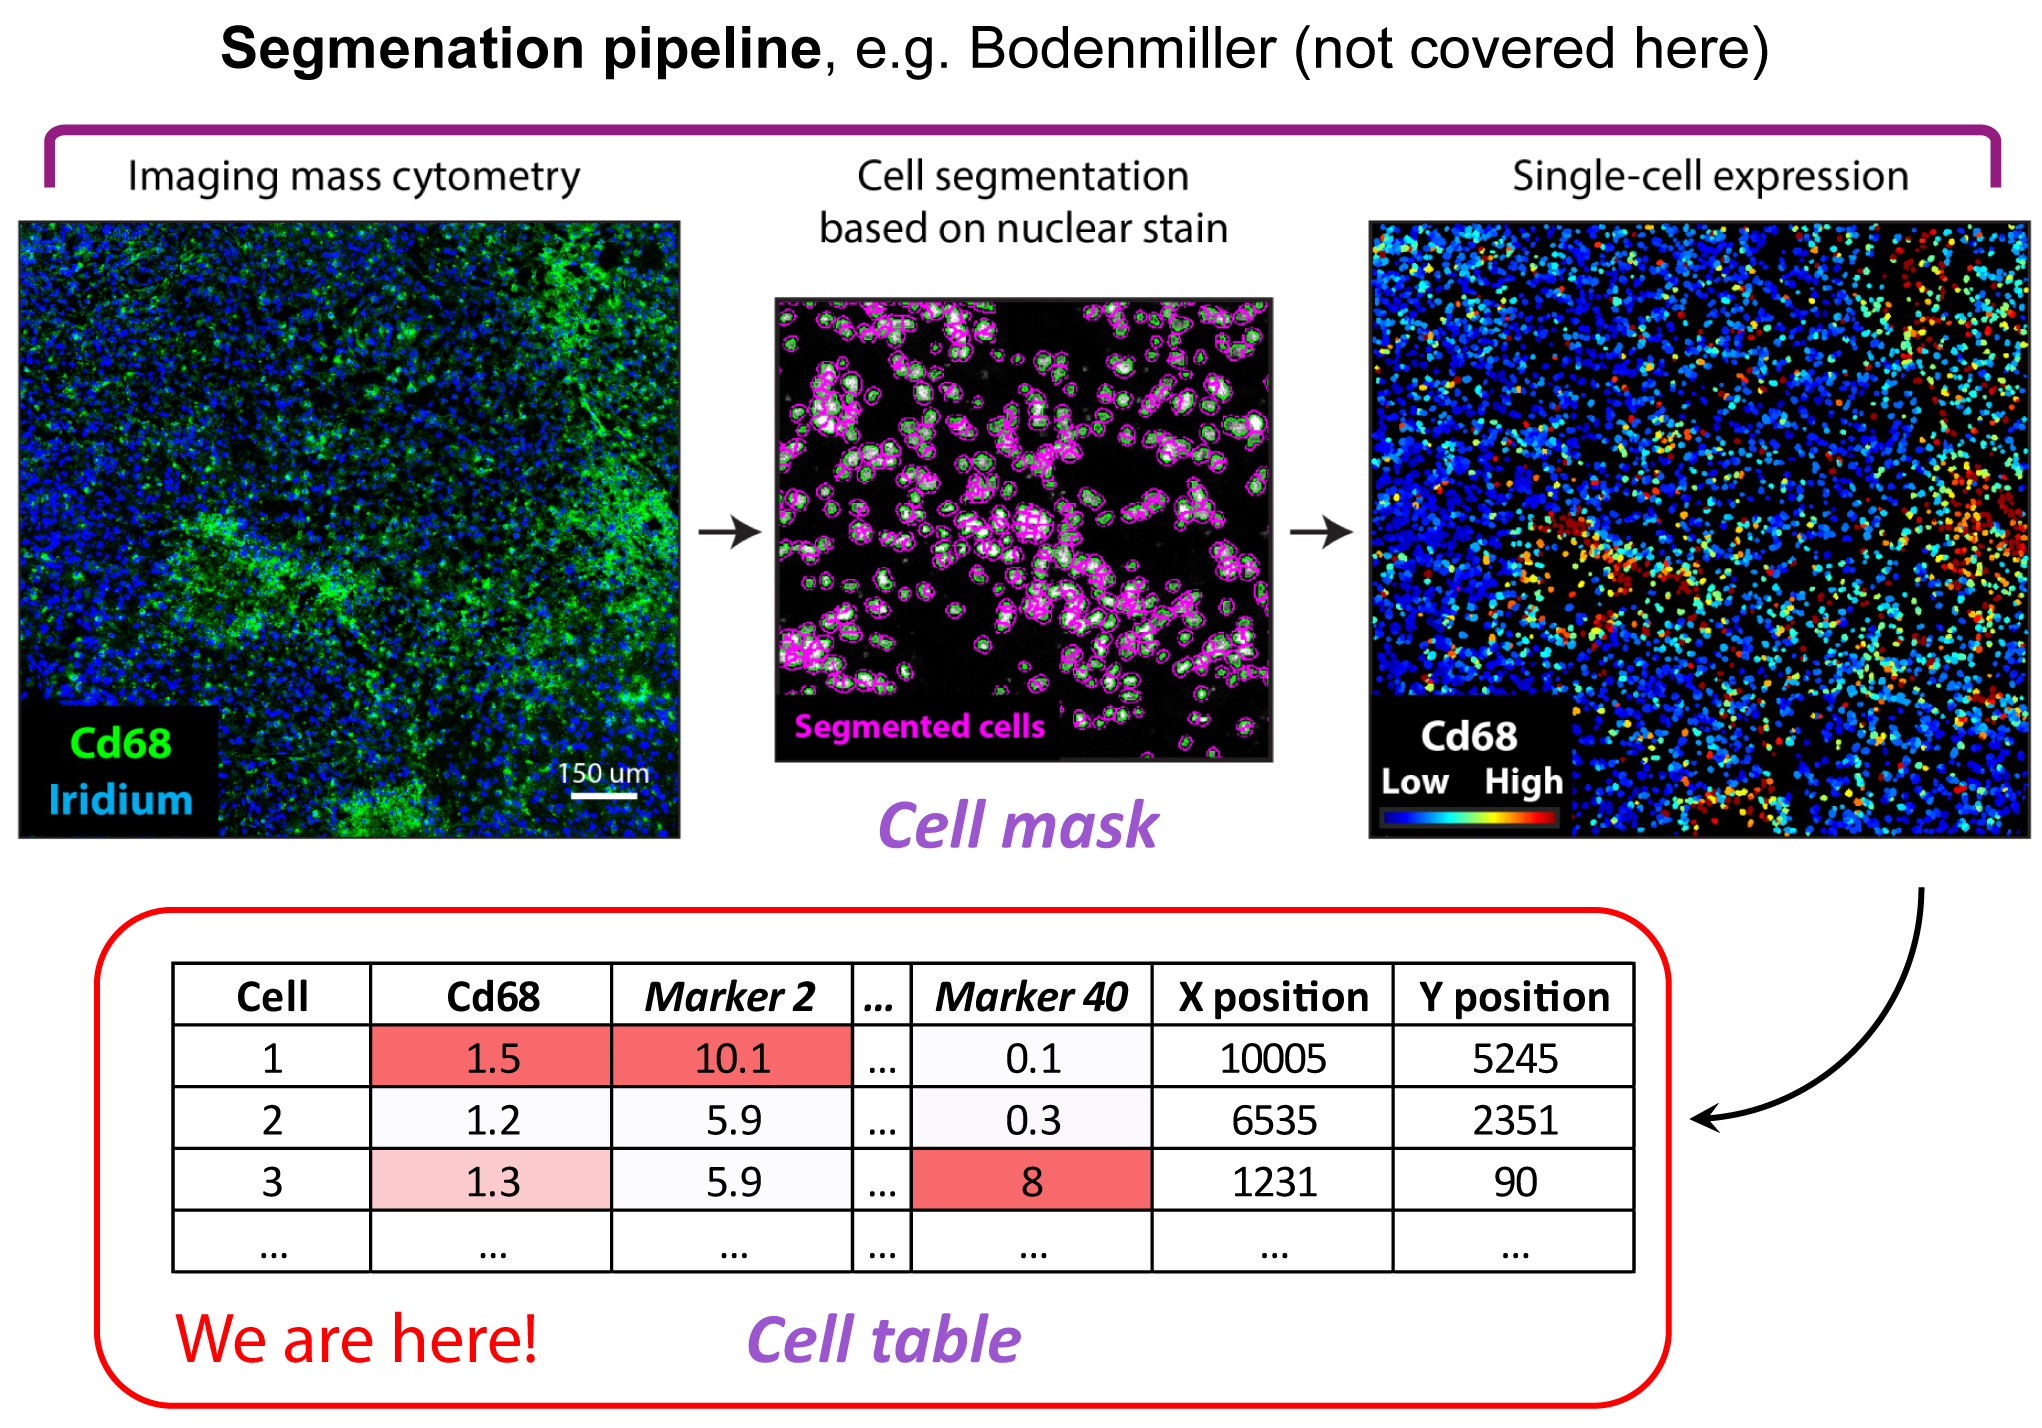

In [1]:
from IPython.display import Image
Image("segmentation.png")

## <font color='blue'>Setting up Python</font>

### 1. Setting up Anaconda
If you haven't yet setup Anaconda on your system, and are viewing this on the Github, there first step is to install and setup **Anaconda** (https://www.anaconda.com/products/distribution)


### 2. Setting up the environment
Once Anaconda is installed, we need to open the Anaconda Powershell Prompt, and create a new environment which we will call IMC (you can call it anything) using Conda. 
>**conda create --name IMC**</br>

We then want to add some channels to Conda where packages will be downloaded from

>**conda config --add channels conda-forge**</br>

>**conda config --add channels bioconda**</br>



We now activate our new environment, and then start installing the packages we will need. This could take a while!

>**conda activate IMC**

>**conda install squidpy scanpy pandas anndata seaborn yaml scikit-image yellowbrick dill umap-learn napari-imc colorcet scikit-learn jupyterlab shapely tqdm git**

Some packages aren't available on Conda, and therefore need to be installed via Pip
>**pip install phenograph**</br>

Athena must also be installed via Pip...
>**pip install ai4scr-spatial-omics ai4scr-athena**</br>

<font color='red'>If you get an error in the above command, try this instead...</font>
>**pip install ai4scr-spatial-omics ai4scr-athena --no-deps**</br>
>**pip install astropy**</br>

Install bbknn, which we use for batch correction
>**pip install bbknn**</br>

<font color='red'>If you got an error in the above mentioning 'Microsoft Visual C++ 14.0 is required', you can download it here, though you will need admin rights:</font>
https://visualstudio.microsoft.com/visual-cpp-build-tools/


### 3. Starting Jupyter
Download this notebook and the **'mikeimc_v2.py'** place them somewhere sensible (e.g. 'C:/Programming', or wherever)

Open Anaconda Powershell and change directories to where you have put the downloaded files. In the above example...
>**cd c:/programming**

Activate the IMC environment. You can tell what environment you are currently in by looking at the start of the command line by default it will be *(base)*, after this is should be *(IMC)*

>**conda activate IMC**

Start Jupyter notebook
>**jupyter notebook**

Open up the Jupyter notebook, and contine below...

## <a id="celltable"><font color='blue'>Required files and setup</font></a>

This pieline assumes you have just finished the final step of the Bodenmiller Pipeline, the last step of which creates a folder called **cpout** in the **analysis** folder.

Copy the **cpout** folder into the same directory as this notebook.

Within the **cpout** folder, there should the following files and folders

- **Image.csv** - Contains metadata for each region of interest
- **cell.csv** - The cell table with all the extracted single cell data
- **panel.csv** - The panel file used in the Bodenmiller pipeline setup
- **masks** - The cell masks
- **images** - The image stacks for the channels

In older versions of the pipeline, you may also have.

- **acquisition_metadata.csv** - Similar to image.csv, contains metadata for each region of interest

## <a id="celltable"><font color='blue'>Tips getting a cell table from the Bodenmiller pipeline</font></a>
If you used the Bodenmiller pipeline, the cell table will be called **'cell.csv'**. However, the columns will not obviously match up with the markers, and it's also not clear which image the cells come from! For the markers, the intensity of each will be in a number columns equal to the number of channels you had in your experiment, each prefixed *'Intensity_MeanIntensity_FullStack'*. The image the cells came from is identified by the column *ImageNumber*. This matches up with a column in the **Image.csv**, in which you can get the ROI names and file names from the colummns that begin with *Metadata_*. If your cell.csv or Image.csv files are missing from the cell profiler output folder, you need to go to the final CellProfiler step in the Bodenmiller pipeline and make sure this information is being exported. Go to the first *ExportToSpreadsheet* entry in CellProfiler, then set  *'Select the measurements to export'* to *No*, if you just want to export everything. This can results in a pretty huge cell table with loads of useless information. Alternatively, select *Yes*, then nake sure *Experiment* and *Image* are ticked. Under *cell*, tick *Location --> Center*, and *Intensity --> MeanIntensity*. This will result in a much smaller cell table.


## <font color='blue'>Creating a dictionary file to add meta information about our cells</font>
Often we have extra meta information about the cells which we would like to include in our analyses, most commmonly these are which patient, sample or group the cells have come from. This metainformation is at the image-level, ie. all cells from the same image will be labelled with the same meta information.

**Save dictionary.csv in the same folder as this noteobok**

<font color='red'>**You no longer need to supply a columns.csv or clean up the cell table**</font>

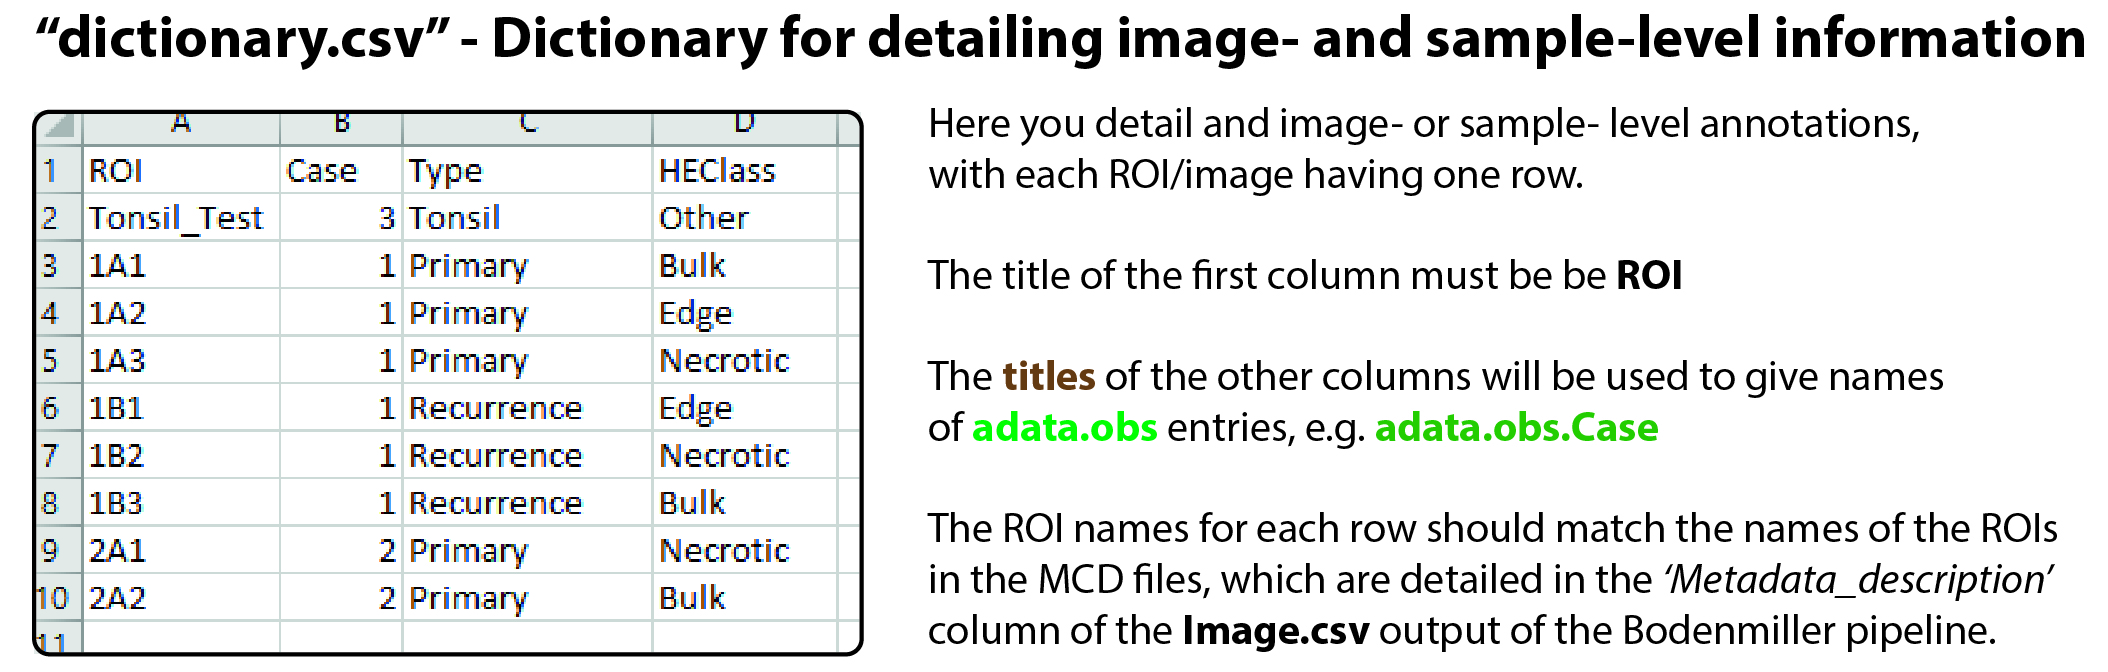

In [1]:
from IPython.display import Image
Image("dictionary.jpg")

## <font color='blue'>Important notes on using this pipeline</font>
When we do analyses in Python, it is important to understand *where* and *how* our data is being stored. Simply, there are 3 different places that our analyses may exist, potentially all at the same time:

*Data and analyes may be stored in....*

#### The Python kernel
This is the instance of Python that you are currrently working in. It has all the variables and objects you have currently defined stored in the memory, allowing us to access and work with them. However, if we close the kernel, or it crashes, **we lose all our analyses!** Usually we can just re-run all the analyses again without an issue, but it's time consuming and annoying. If the browser crashes, that is not an issue - just reopen the browser,  go back to the Jupyter web page (look in your browser 'history' to find the address), and you should be able to pick up where you left off. However, in order to keep Jupyter and the kernel running, do not close the Anaconda prompt you used to start Jupyter, or turn off your computer

#### The Jupyter notebook file (.ipynb)
This stores all your **markdown, code and the outputs** of any analyses you have run - essentially, **if you can see it visually on screen it will be saved in the Jupyter notebook file!**. Jupyter will automaticlaly save periodically. However, if you rerun cells, you lose any previous outputs, unless you have saved them to disk...

#### Exported / saved figures
The safest way to store your analyses and export them out of Python is to store the resulting figures to disk as images, or export any tabular data as spread sheets. 

#### Adata object saved on disk
You can save AnnData (*adata*) objects to disk, and reload them later. This is the a very convenient way to come back to later analyses. Unfortunately, there is no good way to save spatial-omics *so* objects.

<div class="alert alert-block alert-danger">
Do not close the Anaconda Powershell you used to start Jupyter, turn off your computer entirely, or manually restart the kernel <b>unless</b> you have saved your analyses somehow, or don't mind rerunning your analyses (which in some cases may take several hours!)
</div>

# <font color='green'> Importing required packages</font>

<div class="alert alert-block alert-info">
<b>Read the package documentation!</b> I'm not going to give an extended explanation of how the various packages work. Instead, go and read the documentation and papers associated with the main packages I have linked here. This will explain how the different functions work, give worked examples, and explain how you can customise the code. 
</div>

This will import the libraries that we need, including a module I've made called **'mikeimc'** which has some useful functions for processing IMC data - *mikeimc_v2.py* should the in the same directory as this notebook. The other libraries should already be installed if you have setup the environment correctly, if not they won't import here and you will get an error.

### Packages:

##### Scanpy
Single-cell analysis developed for single-cell sequencing, but also works great for IMC.
https://scanpy.readthedocs.io/en/stable/

##### Squidpy
Built on scanpy, expands to do several different spatial analyses
https://squidpy.readthedocs.io/en/stable/
https://www.biorxiv.org/content/10.1101/2021.02.19.431994v1

##### AnnData
Data object used to store all our single cell analyses (in the *adata* object)
https://anndata.readthedocs.io/en/latest/

##### Pandas
Tools for working with tables of data, which is pretty much all the data we will be working with.

##### BBKNN:
Algorithm implemented by Scanpy to do batch correction
https://academic.oup.com/bioinformatics/article/36/3/964/5545955

##### ATHENA and 'spatial omics' object
Developed by a former member of the Bodemiller lab, has a lot more functionality to do in-depth spatial analyses. The problem is that it isn't build directly on an *adata* object, instead using an *so* (spatial omics) object. Therefore, we have to transer all the data from the *adata* to the *so* half way through.

https://github.com/AI4SCR/ATHENA
https://github.com/AI4SCR/spatial-omics
https://histocartography.github.io/athena/index.html


<div class="alert alert-block alert-danger">
<b>CaseViewer/3DHistech Issue</b> If you are having an error where Jupyter crashes and you have CaseViewer or some other 3D Histech software installed, it could be because of the following issue:
https://github.com/lmcinnes/umap/issues/702
</div>

In [ ]:
# Standard libraries for data analysis, most of these should be automatically installed
import numpy as np
import scipy as sp

# Pandas for working with dataframes and tabular data
import pandas as pd

# AnnData for working with anndatas (annotated datas)
import anndata as ad

# Matplotlib and seaborn for plotting
import matplotlib
from matplotlib import rcParams
from matplotlib import colors
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
import seaborn as sb

# For access to good colour maps
import colorcet as cc

# OS and pathlib for opening/deleting files
import os
from pathlib import Path

# Scanpy 
import scanpy as sc
import scanpy.external as sce

# Squidpy
import squidpy as sq

# Import UMAP
# This can cause a crash if CaseViewer is installed! See comment above.
import umap 

#My module for importing IMC data into AnnData format
import mikeimc_v2
import mikeimc_v2 as mimc

#To display multiple dataframes in same output
from IPython.display import display

#ATHENA
from spatialOmics import SpatialOmics
import athena as sh

#Loading bar functionality for long tasks
from tqdm import tqdm

#For multiprocessing
from functools import partial
from multiprocessing import Pool

#### Reload mikeimc

In [ ]:
import mikeimc_v2
import imp
imp.reload(mikeimc_v2)

#### Setup or reset default parameters for plotting

<div class="alert alert-block alert-info">
    <b>Tip</b> Re-run this cell if your plots start looking weird and you're not sure why! 
</div>

In [ ]:
# Reset plotting parameters to their defaults
matplotlib.pyplot.rcParams.update(matplotlib.rcParamsDefault)

# Set up output figure settings
plt.rcParams['figure.figsize']=(5,5) #rescale figures, increase sizehere

# Set up scanpy settings
sc.settings.verbosity = 3
sc.set_figure_params(dpi=100, dpi_save=200) #Increase DPI for better resolution figures

# <font color='green'> Saving / loading AnnData objects </font>
These don't need to be run initially, but will be useful to save and load analyses, or export data to a spreadsheet for external analyses.

<div class="alert alert-block alert-danger">
    <b>Be careful using save and load!</b> There will be no warning if you overwrite the wrong file, or load in an empty adata and therefore lose the one you're working on!
</div>

#### Save adata object
This will save the adata object in the current directory as a file called 'adata'

In [ ]:
adata.write('adata')

# Also save info about panel and samples
try:
    sample_df.to_csv('sample_df.csv')
    panel_df.to_csv('panel_df.csv')
except:
    print('Could not save sample or panel files')
    pass

#### Export cell table
This will export the currently adata.obs, which will give you a table format of all your cells, what populations and results of several key analyses.

In [ ]:
adata.obs.to_csv('adata_obs.csv')

#### Load adata
This will open up a stored adata object (from the 'raw' directory)

In [ ]:
adata = ad.read_h5ad('adata')

# Also save info about panel and samples
try:
    sample_df = pd.read_csv('sample_df.csv', index_col=0)
    panel_df = pd.read_csv('panel_df.csv', index_col=0)
except:
    print('Could not load sample or panel files - consider rerunnning cell "Creating cell_df, panel_df and sample_df"')
    pass

# <font color='green'>Setting up AnnData object</font>

This pieline assumes you have just finished the final step of the Bodenmiller Pipeline, the last step of which creates a folder called **cpout** in the **analysis** folder.

Copy the **cpout** folder into the same directory as this notebook.

Within the **cpout** folder, there should the following files and folders

- **Image.csv** - Contains metadata for each region of interest
- **cell.csv** - The cell table with all the extracted single cell data
- **panel.csv** - The panel file used in the Bodenmiller pipeline setup
- **dictionary.csv** - The dictionary file, which is setup as detailed above, to add in extra observations for cells, e.g what patient they came from
- **masks** - The cell masks
- **images** - The image stacks for the channels

In older versions of the pipeline, you may also have.

- **acquisition_metadata.csv** - Similar to image.csv, contains metadata for each region of interest

<font color='red'>**You no longer need to supply a columns.csv or clean up the cell table**</font>

### Creating *cell_df*, *panel_df* and *sample_df*
This creates various data tables from the raw data outputted from the Bodemiller pipeline, no need to modify

In [ ]:
directory = 'cpout'

# Will look for the following files and directories in the above directory...

panel_file='panel.csv'
cell_file='cell.csv'
image_file='image.csv'
masks_dir='masks'
images_dir='images'

# You may not have this file, don't worry if so
acquisition_metadata='acquisition_metadata.csv'

#######################

# Check the files exist
files = [panel_file, cell_file, image_file, panel_file, masks_dir, images_dir]

for file in files:
    file_path = Path(directory, file)
    if not os.path.exists(file_path):
        raise TypeError(f"Error: {file} does not exist in {directory}")
    
# Import the files
panel_df = pd.read_csv(Path(directory,panel_file), low_memory=False)
image_df = pd.read_csv(Path(directory,image_file), low_memory=False)
cell_df = pd.read_csv(Path(directory,cell_file), low_memory=False)

# acquisition_metadata is output by some older versions of Bodeniller pipeline        
try:
    metadata_df = pd.read_csv(os.path.join(directory,acquisition_metadata), low_memory=False)
except:
    print('No metadata file found')

masks_dir = Path(directory, masks_dir)
images_dir = Path(directory, images_dir)

# Filter down the panel to only those in FullStack, and then drop columns we don't need
panel_df = panel_df.loc[panel_df['full']==True,:].drop(columns=['full','ilastik'])

# Create a column that maps the channels with the column names all they will appear in the CellProfiler cell table
panel_df['cell_table_channel'] = [('Intensity_MeanIntensity_FullStack_c'+str(i+1)) for i, _ in enumerate(panel_df.index)]

panel_df.index = np.arange(1, len(panel_df) + 1)

# Extract only the intensities from the cell table
cell_df_intensities = cell_df[[col for col in cell_df.columns if 'Intensity_MeanIntensity_FullStack' in col]].copy()

# Remap the column names to the proper channel names
try:
    panel_df.rename(columns={'Label':'Target'}, inplace=True)
except:
    pass

mapping = dict(zip(panel_df['cell_table_channel'],panel_df['Target']))
    
cell_df_intensities.rename(columns=mapping, inplace=True)

# Will first try and use the image_df, which should work with the newest version of the Bodenmiller pipeline
try:
    # Setup a dataframe with ROI-level information
    sample_df=image_df.loc[:,['FileName_FullStack', 'FileName_cellmask','Metadata_acname', 'Metadata_description', 'Width_FullStack', 'Height_FullStack', 'ImageNumber']]
    sample_df=sample_df.rename(columns={'Metadata_acname':'MCD_File', 'Metadata_description':'ROI', 'Metadata_max_x':'Size_x', 'Metadata_max_y':'Size_y'}).set_index('ROI')
    sample_df['AcSession']=[x[:-10] for x in sample_df['FileName_FullStack']]
    
# Alternatively, will use acquisition_metadata.csv from older versions of the pipeline
except:
    print('Couldnt find info in image_df, using acquisition_metadata instead...')
    # Setup a dataframe with ROI-level information
    sample_df=metadata_df.loc[:,['AcSession', 'description', 'max_x', 'max_y']]
    sample_df=sample_df.rename(columns={'description':'ROI', 'max_x':'Size_x', 'max_y':'Size_y'}).set_index('ROI')
    sample_df['FileName_FullStack']=sample_df['AcSession']+'_full.tiff'
    sample_df['FileName_cellmask']=sample_df['AcSession']+'_ilastik_s2_Probabilities_mask.tiff'
    sample_df['ImageNumber']=sample_df['FileName_FullStack'].map(dict(zip(image_df['FileName_FullStack'], image_df['ImageNumber'])))
    
sample_df['mm2']=(sample_df['Size_x']/1000)*(sample_df['Size_y']/1000)

sample_df.to_csv('sample_df.csv')
panel_df.to_csv('panel_df.csv')

## Setup imaging folders

This will create **mask** and **image** folders in the current directory.

In [ ]:
mikeimc_v2.stacks_to_imagefolders(input_folder=images_dir,
                           masks_folder=masks_dir,
                            panel_df=panel_df,
                            sample_df=sample_df)

## <font color='purple'>OPTIONAL, NOT RECOMMENDED - Normalisation method optimisation</font>

This will test several ways of normalising your data, and probably isn't required.

**This will take ages to run, leave over weekend**

In [ ]:
mikeimc_v2.normalisation_optimisation(cell_dfs=cell_df,
                              sample_df=sample_df,
                              panel_df=panel_df, 
                              image_df=image_df,
                              cell_table_format='bodenmmiller',
                              cell_df_ROIcol='ROI',
                              marker_normalisation_list=[['nonorm'],['q99.99'],['q99.9'],['q99'],['arcsinh5'], ['arcsinh5', 'q99.99'],['arcsinh5', 'q99.9'],['arcsinh5', 'q99']],
                              batch_correction_list=['none','bbknn'],
                              umap_categories=['ROI','Case'],
                              batch_correct_obs='Case',
                              clustering=True,
                              clustering_resolution=0.3)

## Create AnnData object

This will create the anndata object

In [ ]:
adata_fullimport = mikeimc_v2.setup_anndata(cell_df=cell_df,
                  sample_df=sample_df,
                  panel_df=panel_df, 
                  image_df=image_df,
                  cell_df_x='Location_Center_X', #Default output from Bodenmiller, no need to change
                  cell_df_y='Location_Center_Y', #Default output from Bodenmiller, no need to change
                  cell_df_ROIcol='ROI',  #Default output from Bodenmiller, no need to change
                  dictionary='dictionary.csv',
                  cell_table_format='bodenmmiller', 
                  cell_df_ROIcol='ImageNumber', #Default output from Bodenmiller, no need to change
                  marker_normalisation='q99.9') #Markers are normalised to the 99.9 percentile, ie scaling them from 0 to 1
                                           

## Removing unused markers and ROIs

Use this code to remove any markers or samples which you don't want included in your final adata that you'll be using for analyses. For example, any test regions, or markers that you know for certain haven't worked at all.

<font color='blue'>This will need changing depending on what ROIs (**obs_to_remove**) or markers (**markers_to_remove**) you want to remove!</font>

In [ ]:
adata = mikeimc_v2.filter_anndata(adata_source=adata_fullimport,
                            markers_to_remove=['DNA1', 'DNA3'], #List of markers to remove, e.g, DNA markers, but also any 
                            obs_to_filter_on='ROI', #The .obs category which you want to filter on
                            obs_to_remove=['Test1', 'Test2']) #The types of .obs you want removing - in this example we're removing 'Test1' and 'Test2'.

# Print a list of the variables that appear in the working anndata
print(adata.var_names)

# Print the structure of the working anndata
print(adata)

## Convert some columns to category
This will save headaches in later stages - makes sure that all categorical variables in obs are stored as categories.

<font color='blue'>This will need changing depending on what extra columns you added from your **'observations' in the cell table, or information added in the dictionary.csv**</font>

In [ ]:
# This will list out the columns you may want to now convert...
adata.obs.columns.tolist()

In [ ]:
categorical_obs=['ROI','Case', 'Disease_Severity', 'Growth_Rate','Histopathology','Abnormal_Vasculature','Matrix_Deposition', 'Treatment_Status', 'Primary_recurrent']

In [ ]:
# Alter this with the categorical obs from above
for i in categorical_obs:
    adata.obs[i]=adata.obs[i].astype('category')

## Very quick QC check of data
Some simple QC checks - look at expression of all the markers in each ROI in a heatmap

In [ ]:
# The title of  the column in which defines each image/region of interest
image_var = 'ROI'

# Plot a heat of all the markers
sc.pl.matrixplot(adata, adata.var_names, groupby=image_var)

# <font color='green'>Image maker</font>
This function will create RGB images using up to 7 channels, similar to MCD Viewer or ImageJ

### Args:

**image_folder**:
    The folder with the source images. In this folder, each ROI should have its own subfolder, with the folder named after the ROI.

**samples_list**:
    List of samples to use from the image_folder. Only these samples will be used for auto-exposure if using quatiles (which is the default)

**output_folder**:
    Output folder for images

**name_prefix**:
    A prefix that will be put at the front of the file names

**minimum**:
    The default minimum value (see 'range' below')

**max_quantile**:
    The default max staining, which is the 97th quantile

**{colour}**:
    The name of the marker to use for that colour

**{colour_range}**:
    You can specify the range that should be the maximum and minimum, using the format (minimum, maximum). Both are specified by raw counts by default. However, if you put in a 'q' before a number, it will use that quantile range instead. e.g. 'q0.99' will use the 99th percentile as the maximum.

### Returns:
Saves a .png per roi in the specified output directory

In [ ]:
mikeimc_v2.make_images(image_folder='images', 
                samples_list=adata.obs.ROI.unique().tolist(), #This will do all ROIs
                output_folder='images_output',
                name_prefix='',
                minimum=0.2,
                max_quantile='q0.97',
                red='iba1',
                red_range=None,
                green=None,
                green_range=None,
                blue='DNA1', 
                blue_range=None,
                magenta=None,
                magenta_range=None,
                cyan=None,
                cyan_range=None,
                yellow=None,
                yellow_range=None,
                white=None,
                white_range=None,
                roi_folder_save=False,
                simple_file_names=False,
                save_subfolder='')

# <font color='green'> Batch integration using BBKNN </font>
This will batch correct using BBKNN. There are other options batch correction, such as Harmony, but I found this the easiest to implement. Read more here: https://bodenmillergroup.github.io/IMCDataAnalysis/batch-effects.html

#### Run PCA and BBKNN

<font color='blue'>**batch_correction_obs** -This defines which .obs should be used to identify the different batches, in the example here it is 'Case'</font>

In [ ]:
# Define the number of PCA dimensions to work with - one less than number of markers. Without this, it usually defaults to 50, which we don't have enough markers for.
n_for_pca = len(adata.var_names)-1

# Define the 'obs' which defines the different cases
batch_correction_obs = 'Case'

# Calculate PCA, this must be done before BBKNN
sc.tl.pca(adata, n_comps=n_for_pca)

# BBKNN - it is used in place of the scanpy 'neighbors' command that calculates nearest neighbours in the feature space
sc.external.pp.bbknn(adata, batch_key='Case', n_pcs=n_for_pca)

# <font color='green'>UMAPs</font>

#### Calculate UMAP

In [ ]:
sc.tl.umap(adata)

#### Plot UMAPs
<font color='blue'>You can add extra .obs to **UMAP_groups** to colour the UMAPs by, e.g. treatment</font>

In [ ]:
figure_dir=Path('Figures','UMAPs')
os.makedirs(figure_dir, exist_ok=True)

#Define a list of .obs to colour the UMAP by
UMAP_groups = categorical_obs#['ROI'] 

# Plot UMAPs coloured by list above
fig = sc.pl.umap(adata, color=UMAP_groups, ncols=1, size=10, return_fig=True)
fig.savefig(Path(figure_dir, 'Categorical_UMAPS.png'), bbox_inches='tight', dpi=300)

# This will plot a UMAP for each of the individual markers
fig = sc.pl.umap(adata, color=adata.var_names.tolist(), color_map='plasma', ncols=4, size=10, return_fig=True)
fig.savefig(Path(figure_dir, 'Marker_UMAPS.png'), bbox_inches='tight', dpi=300)

In [ ]:
mikeimc_v2.print_full(adata.obs.ROI.value_counts())

# <font color='green'>Population identification</font>

## Initial population identification using Leiden clustering
This is the same algorithm used by PhenoGraph, and is more or less the same

#### Initial Leiden clustering

<font color='blue'>**resolution** - Change this to alter the size of the clusters - small resolution results in bigger clusters (therefore, less clusters overall, but each with more cells). </font>

Feel free to re-run this with several different resolutions, to see which looks best!

import random
adata.obs['population']=[random.randint(1, 6) for _ in range(len(df))]

In [ ]:
# Change this to alter the size of the clusters - small resolution results in bigger clusters (therefore, less clusters overall, but each with more cells)
resolution = 0.3
leiden_obs_name = 'leiden_'+str(resolution)

# This will perform the clustering, then add an 'obs' with name specified above, e.g leiden_0.35
sc.tl.leiden(adata, resolution=resolution, key_added = leiden_obs_name) 

#### Plot initial clustering results

In [ ]:
image_var = 'ROI' # The adata.obs that defines each image or ROI

sc.set_figure_params(figsize=(5, 5))
sc.pl.umap(adata, color=leiden_obs_name,size=2)

# Delete old dendrograms
try:
    del adata.uns[f'dendrogram_{leiden_obs_name}']
except:
    pass

# Plot a heatmap
sc.pl.matrixplot(adata,
                 adata.var_names.tolist(), 
                 groupby=leiden_obs_name, 
                var_group_rotation = 0,
                vmax=0.6,
                dendrogram=True)

# Alter this list with adata.obs variables that you want to plot against the resulting leiden population
for i in ['Case']:

    mikeimc_v2.grouped_graph(adata,
                             ROI_id=image_var,
                             group_by_obs=i,
                             x_axis=leiden_obs_name,
                             fig_size=(10,3),
                             log_scale=True,
                            display_tables=False) #If you change display_tables to True, will also do stats on the groups
    plt.show()

#### Sub clustering example
Once you've done the initital subclustering, which could be with a fairly low resolution, you can then do subclustering on specific clusters from previous Leiden analyses

<font color='blue'>**resolution** - As above. Change this to alter the size of the subclusters of the previous analysis </font>


In [ ]:
# Change this to alter the size of the clusters in the subclustering
resolution = 0.2
leiden_obs_name = 'leiden_'+str(resolution)

# In the following example, it will do a leiden clustering based upon the the results of 'leiden_1', selecting population 2
sc.tl.leiden(adata, resolution=resolution, key_added = leiden_obs_name, restrict_to=('leiden_1',['2'])) 

## <font color='purple'>OPTIONAL - Subclustering with different markers</font>

This is optional extra that will see if you can subcluster using a different set of markers, as the subclustering options above use the same markers. The only drawback is that it creates a new AnnData object which you'll have to analyse separately. If you're unsure what any of this means, then don't use it.

In [ ]:
# Create a list of the markers we want to use in the subanalysis, in this example we're focusing on our myeloid markers
myeloid = ['Iba1','CD14','CD16','CD44','CD11c','CD206','CX3CR1','HLA-DR', 'CD163', 'CD68']

In [ ]:
# This will create a brand new adata object with just myeloid cells in 
adata_myeloid = mikeimc_v2.adata_subclustering(adata,
                        population_obs='leiden_0.35', #This is the leiden which you want to to use to identify myeloid populations in your original Leiden
                        populations=['4'], #List of populations from the above population_obs
                        marker_list=myeloid, #List of markers to use
                        clustering_resolutions=[0.1, 0.25, 0.4, 0.7], #Clustering resolutions to try
                        umap_categories=['ROI','Case'],
                        batch_correct='bbknn', #Whether to batch correct, otherwise but None if you dont want to correct
                        batch_correct_obs='Case', #Which .obs to use for batch correction
                        close_plots=True)

This next function will transfer the popuation labels from one adata and .obs to another. This relies upon all cells having a unique ID inthe 'Master_Index' column of .obs

In [ ]:
mikeimc_v2.transfer_populations(adata_source=adata_myeloid,
                                 adata_source_populations_obs='leiden_0.1',
                                 adata_target=adata,
                                 adata_target_populations_obs='leiden_0.35',
                                 common_cell_index='Master_Index',
                                 pop_prefix='NEW')

## Plot final clustering results

In [ ]:
image_var = 'ROI' # The adata.obs that defines each image or ROI

sc.set_figure_params(figsize=(5, 5))
sc.pl.umap(adata, color=leiden_obs_name,size=2)

# Delete old dendrograms
try:
    del adata.uns[f'dendrogram_{leiden_obs_name}']
except:
    pass

# Plot a heatmap
sc.pl.matrixplot(adata,
                 adata.var_names.tolist(), 
                 groupby=leiden_obs_name, 
                var_group_rotation = 0,
                vmax=0.6,
                dendrogram=True)

# Alter this list with adata.obs variables that you want to plot against the resulting leiden population
for i in ['Case']:

    mikeimc_v2.grouped_graph(adata,
                             ROI_id=image_var,
                             group_by_obs=i,
                             x_axis=leiden_obs_name,
                             fig_size=(10,3),
                             log_scale=True,
                            display_tables=False) #If you change display_tables to True, will also do stats on the groups
    plt.show()

## Label final populations

#### Remapping populations
Here we are creating 'dictionaries' that will remap the population numbers from the Leiden clustering, to actual names.

<font color='blue'>**Change these lists to match the Leiden population numbers, to actual populations that you identfy based upon marker expression**</font>

I've usually been working with 3 different labels.  
**populations** - This is the exact population name for that Leiden population. If you give two numbers the same name, they will be combined (e.g. 10 and 14 below).

**hierarchy** - This gives a more broad hierarchy for the populations, allowing us to specicfy analyses only be done on certain cell types.

**populations_broad** - This is a combination of populations and hierarchy, and what I've mostly used in subsequent analyses. For my analyses that mostly focused on myeloid cells, I decided to combine all the different tumour types into one label ('Tumour'), but still keep all the myeloid populations.

<font color='blue'>**leiden_obs_name** - The name of the final leiden clustering that you want to use to assign populations</font>


In [ ]:
leiden_obs_name = 'leiden_0.2' #This will depend on what subclustering you did

populations={'0':'Pop0',
'1':'Pop1',
'2':'PanCyto+Tim3+',
'3':'MHCI',
'4':'Vascular',
'5':'CAIX',
'6':'CD206',
            }
    
adata.obs['population']=adata.obs[leiden_obs_name].map(populations).astype('category')

#### Plotting final populations with new names

In [ ]:
for i in ['population']:
    
    # Delete old dendrograms
    try:
        del adata.uns[f'dendrogram_{i}']
    except:
        pass
    
    sc.set_figure_params(figsize=(5, 5), dpi=200)
    sc.pl.umap(adata, color=i,size=2)
        
    sc.pl.matrixplot(adata,
                     adata.var_names, 
                     groupby=i, 
                    var_group_rotation = 0,
                    vmax=0.7,
                    dendrogram=True)

# <font color='green'>Create list of final populations</font>

Create a list of the final populations we want to take forward for further analyses.

In [ ]:
population_obs_list = ['population']

# <font color='green'>Backgating assessment</font>

This will do a backgating assessment. This identifies a specific number of cells from each subpopulation of a population obs (ie, leiden cluster), then plots each population mask over a RGB image with the top 3 highest channels for each population. There is a fair amount of flexibility in this function.

#### Args:
**adata**: adata object

**image_folder**: Folder with raw or denoised images. Each ROI has it's own folder.

**pop_obs**: adata.obs that identifies populations

**cells_per_group**: Cells per group to plot

**radius**: Size of square over cell to visualise

**roi_obs**: adata.obs identifying ROIs

**minimum**: Minimum pixel value for images

**max_quantile**: Quantile of signal for max intensity of images

**markers_exclude**: List of markers to exclude when calculating highest expression of markers in group

**only_use_markers**: Supply a list of markers to use when calculating highest expression of markers in group

**number_top_markers**: Number of highest expression of markers, between 1 and 3

**mode**:
- 'full': Will calculate top markers, then immediately backgate
- 'save_markers': Will only calculate markers then save in a file, which can be reviewed and modified
- 'load_markers': Loads a saved marker file, then runs backgating           

**specify_red**:Specify a channel which all pops will use for red

**specify_green**:Specify a channel which all pops will use for green

**specify_blue**:Specify a channel which all pops will use for blue

#### Output:
Will save everthing to output, with each population having it's own subfolder   


In [ ]:
# Specify th population to backgate
population_obs='leiden_1'

######

mikeimc_v2.backgating_assessment(adata=adata,                          
                      image_folder='images',
                      pop_obs=population_obs,
                      cells_per_group=50,
                      radius=15, 
                      minimum=0.6,
                      max_quantile='q0.99',
                      mode='full',
                      number_top_markers=2,
                      markers_exclude=[],
                      specify_blue='DNA1',
                      output_folder='Backgating'
                     )

# <font color='green'> ATHENA setup</font>
This will transfer the Adata into ATHENA for more complex spatial analyses

In [ ]:
def align_obs(adata, so, ROI_obs='ROI', cell_index='Master_Index'):
    
    so_samples=so.spl.index()
    adata_samples=adata.obs[ROI_obs].cat.categories.tolist()
    
    assert [x for x in so_samples if x not in adata_samples] == [x for x in adata_samples if x not in so_samples], 'ROIs in SO and AnnData do not match'
    
    so_cols = [so.obs[s].columns.tolist() for s in so_samples]
    assert all(element == so_cols[0] for element in so_cols), 'SO obs tables do not have identical columns'
    
    adata_cols = adata.obs.columns.tolist()
    
    # Work out columns that arent in the other object
    adata_to_so_cols = [x for x in adata_cols if x not in so_cols]
    so_to_adata_cols = [x for x in so_cols if x not in adata_cols]
    
    for c in adata_to_so_cols:
        
        print(f'Mapping {c} from AnnData to SO....')
        
        mapping = dict(zip(adata.obs[cell_index], adata.obs[c]))
        
        for s in so_samples:
            so.obs[s][c]=so.obs[s].index.map(mapping)
            
    for c in so_to_adata_cols:
        
        print(f'Mapping {c} from AnnData to SO....')
        
        mapping = dict(zip(adata.obs[cell_index], adata.obs[c]))
        
        for s in so_samples:
            so.obs[s][c]=so.obs[s].index.map(mapping)
                
            
    
    
    
    
    
    
    


In [ ]:
dictionary = pd.read_csv('dictionary.csv')

so, colour_maps = mikeimc_v2.athena_from_adata(adata,
                              sample_df=sample_df,
                                sample_level_obs=dictionary.columns.tolist(),
                             population_obs_list=population_obs_list)

# <font color='red'>Colour picker</font>
This code occassionally causes the Kernel to crash, so probably avoid using for now

#mikeimc_v2.recolour_population(so=so, 
                               population_obs='population', 
                               colour_maps=colour_maps)

# <font color='green'> ATHENA calculations</font>
Most of this section you should just be able to run 'as is', but it can take a **long time!** Best to leave running over night!

## Graph construction

This will construct the different spatial connectivity graphs, these define which cells are considered neighbours for later analyses.

use your extracted cell locations to build a {radius, knn} graph (it does not use the cellmasks)

you need to define the 'r' parameter to a specific ROI, otherwise the code runs only for the last ROI in the SO object. Or the original code does not work.

#### Setup

In [ ]:
# This select which samples to use - all by default
samples = so.spl.index 

# Import the default graph settings
from athena.graph_builder.constants import GRAPH_BUILDER_DEFAULT_PARAMS

#### Extract centroids from masks
We can define where cells are in two ways - either from the centre of the mask or from the cell locations extracted from the cell profiler pipeline. In theory, they should be almost identical, and in previous tests they are.

In [ ]:
# Extract cell centroids across all samples
for r in tqdm(so.obs.keys()):
    sh.pp.extract_centroids(so, r, mask_key='cellmasks')

#### KNN graph
<font color='blue'>k nearest neighbors - change **'number_neighbours'** to define number of nearest neighbors to identify per cell. Default is 6 </font>


The graph key will be knn_[number_neighbours]

In [ ]:
number_neighbours = 6

#kNN graph, without cellmasks, using predetermined X, Y locs
config = GRAPH_BUILDER_DEFAULT_PARAMS['knn']
config['builder_params']['n_neighbors'] = number_neighbours # set parameter k
for spl in tqdm(samples):
             sh.graph.build_graph(so, spl,
                     key_added='knn_'+str(number_neighbours),
                     builder_type='knn', mask_key=None, coordinate_keys=('X_loc', 'Y_loc'), config=config) 

#### Radius graph

<font color='blue'>Defines a cells neighbours using a radius (in um) from the cell. Default is 20</font>

The graph key will be radius_[radius]

In [ ]:
radius = 20

# radius graph without cellmasks, using my predetermined X, Y locs
config = GRAPH_BUILDER_DEFAULT_PARAMS['radius']
config['builder_params']['radius'] = radius
for spl in tqdm(samples):
             sh.graph.build_graph(so, spl,
                     key_added='radius_'+str(radius),
                     builder_type='radius', mask_key=None, coordinate_keys=('X_loc', 'Y_loc'), config=config)

#### Contact graph (with multiprocessing)
Defines neighbours using direct cell-cell contact using cell mask

In [ ]:
# Use parallel processing?
parallel = True

# This select which samples to use - all by default
samples = so.spl.index.tolist() #so.spl.index 

# Number of cores to use for parallel processing
num_cores = 4

# Run the paralell processing
if parallel==True:
    
    contact_graph_partial = partial(mikeimc_v2.contact_graph, so)
    
    with Pool(processes = num_cores) as pool:      
        data = pool.map(contact_graph_partial, tqdm(samples))
        print('Complete')
    
    for spl,grph in zip(samples,data):

        if spl in so.G:
            so.G[spl].update({'contact': grph})
        else:
            so.G[spl] = {'contact':grph}
    
    print('Added back into original SO!')
    
elif parallel==False:
    
    for spl in samples:
        try:
            sh.graph.build_graph(so, spl, builder_type='contact', mask_key='cellmasks')
        except KeyboardInterrupt:
            pass
        except BaseException as err:
            print("An exception occurred in calculating contact graph for " + spl)
            print(f"Unexpected {err=}, {type(err)=}")        

## Cell-level scores

In their original deﬁnition, all entropic scores described above do not take the spatial component into account when calculated on a whole tumor level. For this reason, ATHENA implements two ﬂavors of these scores: a global ﬂavor, in which the metrics are computed at a whole sample level using only the phenotype distribution, and a local ﬂavor, in which the scores are computed at a single-cell level, using also the graph structure. Speciﬁcally, when computing local scores, ATHENA iterates over all cells, and for each cell, computes the local entropy within its neighborhood. In this way, highly diverse regions where cells from multiple diferent phenotypes coexist can be highlighted, and, instead of computing a single entropy value as for the global ﬂavor, a distribution of entropic values is returned.

Cell-level scores quantify heterogeneity in a spatial manner, accounting for local effects, and return a value per single cell, saved in so.obs. To apply these scores to the data we use again .metrics but this time with local=True. Since these scores heavily depend on the tumor topology, the graph type and occasionally additional parameters also need to be provided.

#### Calculate richness, shannon and quadratic entropy (with multiprocessing)

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Population identifiers
obs = [f'{x}_id' for x in population_obs_list]

# Use parallel processing?
parallel = True

# Get a list of all samples
all_samples = so.spl.index.values

# Number of cores to use for parallel processing
num_cores = 4

# Get a list of existing .obs
exising_obs = so.obs[samples[0]].columns.tolist()

# Get a list of graphs
graph_keys = list(so.G[all_samples[0]].keys())
#graph_keys = ['contact']


# Setting up lists for either parallel or normal processing
s_list=[]
o_list=[]
g_list=[]

for g in graph_keys:
    for s in all_samples:
        for o in obs:    
            o_list.append(o)
            s_list.append(s)
            g_list.append(g)

pool_func_input=list(zip(s_list,o_list,g_list))

# To keep the same 'so' object passed every time
cell_metrics_partial = partial(mikeimc_v2.cell_metrics, so)

# Parallel processing option
if parallel==True:
       
    with Pool(processes = num_cores) as pool:
        data = pool.starmap(cell_metrics_partial, tqdm(pool_func_input, total=len(pool_func_input)))
        print('Complete')

    data_iter = iter(data)
    for s, _, _ in pool_func_input:        
        so.obs[s] = pd.concat((so.obs[s], next(data_iter)), axis=1)

    print('Added back into original SO!')
        
        
# Non-parallel processing option        
elif parallel==False:

    for s, o, g in tqdm(func_input):

        try:
            sh.metrics.richness(so, s, o, local=True, graph_key=g)
            sh.metrics.shannon(so, s, o, local=True, graph_key=g)
            sh.metrics.quadratic_entropy(so, s, o, local=True, graph_key=g, metric='cosine')              
        except KeyboardInterrupt:
            pass  
        except BaseException as err:
            print(f'Error caclculating sample:{s}, graph:{g}, observation:{o}')
            print(f"Unexpected {err=}, {type(err)=}")  

# This will delete duplicate columns in the .obs
#for i in all_samples:
#    so.obs[i]=so.obs[i].loc[:,~so.obs[i].columns.duplicated()].copy()

new_obs = so.obs[samples[0]].columns.tolist()

# Create a list of cellmetrics obs to graph later
cellmetrics_obs = [m for m in new_obs if m not in exising_obs] 

## Cell type interactions

mode: it can be classical, histocat or proportion

Classic: In the classic ﬂavor of the neighborhood analysis score, the average number of interactions between cells of the same phenotype is computed.

HistoCAT: In the histoCAT ﬂavor, the global average of interaction score is only computed across cells that actually show this interaction.

Proportional: Finally, the proportional ﬂavor uses interaction frequencies instead of counts, i.e., divides the counts of pairwise interactions by all interactions a given cell has. We propose this approach as an alternative that normalizes the scores with respect to varying cell density. In contrast to the classic or the histoCAT ﬂavor, the proportional ﬂavor is not inﬂuenced by the number of cells in a sample and the score is bounded in the range of [0,1].

graph_key can be knn, radius or contact

prediction_type can be observation, pvalue or diff
In addition to a p-value, we propose to compute the di↵erence between the observed proportion of interactions obs ij between cell type i ! j and the randomised proportion of interactions rand ij . This di↵erence can be asymmetrical (i ! j = 6 j ! i), is bounded in the range of [-1,1], and might be more suited as input for certain machine learning models.

#### Calculate all potential interaction metrics (with multiprocessing)

In [ ]:
# Use parallel processing?
parallel = True

# Number of cores to use for parallel processing
num_cores = 4

# Get a list of all samples
all_samples = so.spl.index.values

# Modes to run the analyses in
calc_modes = ['proportion']#['proportion', 'histoCAT', 'classic']

# Population identifiers
pop_ids = [f'{x}_id' for x in population_obs_list]

# Get a list of all graphs
graph_keys = list(so.G[all_samples[0]].keys())


import logging
logging.getLogger().setLevel(logging.ERROR)  # set logger to logging.INFO if you want to see more progress information

# Create blank lists
m_list=[]
o_list=[]
s_list=[]
g_list=[]

# Creates several parallel lists with the order of inputs we will need to call in the pool function
for m in calc_modes:
    for o in pop_ids:
        for s in all_samples:
            for g in graph_keys:
                m_list.append(m)
                o_list.append(o)
                s_list.append(s)
                g_list.append(g)

neigh_int_partial = partial(mikeimc_v2.neigh_int, so)

# Create a 'list of lists' for the pool.starmap
pool_func_input=list(zip(m_list,o_list,s_list,g_list))


if parallel==True:
          
    with Pool(processes = num_cores) as pool:
        data = pool.starmap(neigh_int_partial, tqdm(pool_func_input, total=len(pool_func_input)))
        print('Multiprocessing complete')
                      
    data_iter = iter(data)
    for m, o, s, g in pool_func_input:
        key = f'{o}_{m}_diff_{g}'
        sh.neighborhood.estimators.add2uns(so, next(data_iter), s, 'interactions', key) 

    print('Added back into original SO!')
            
elif parallel==False:
    
    for m, o, s, g in tqdm(func_input):
        try:
            sh.neigh.interactions(so, s, o, mode=m, prediction_type='diff', graph_key=g)    
        except KeyboardInterrupt:
            pass  
        except BaseException as err:
            print(f'Error caclculating sample:{s}, graph:{g}, observation:{o}, mode:{m}')
            print(f"Unexpected {err=}, {type(err)=}")
            
logging.getLogger().setLevel(logging.INFO)

# <font color='green'> Spatial mapping of cells</font>
Cell populations can be spatially plotted using a couple of different ways.

## Cells as dots (& specify which subpopulations)

In [ ]:
# Specify list of population_obs to plot - by default will do all
plotting_population_obs_list = population_obs_list

# Specify the subfolder in 'Mapped_populations' where images should be saved
subfolder='Plotting'

# Specify specific populations within population_obs to plot - if blank will plot all
pops_to_plot=[]

#######################################

for pop_obs in plotting_population_obs_list:
    for i in so.spl.index:

        fig, ax = plt.subplots(figsize=(10,10))

        if pops_to_plot != []:
            data = adata.obs[(adata.obs.ROI==i)&(adata.obs[pop_obs].isin(pops_to_plot))]
        else:
            data = adata.obs[adata.obs.ROI==i]

        sb.scatterplot(data = data,
                           x = 'X_loc',
                           y='Y_loc',
                           hue=pop_obs,
                           ax=ax,
                         palette = colour_maps[pop_obs],
                        edgecolor=None, #or 'black' or 'white'
                        s=100)

        ax.invert_yaxis()
        ax.set_xticks([])
        ax.set_yticks([])

        ax.set_xlim(0,adata.uns['sample'].loc[i,'Size_x'])
        ax.set_ylim(0,adata.uns['sample'].loc[i,'Size_y'])

        ax.grid(False)
        #ax.get_legend().remove()
        ax.legend(bbox_to_anchor=(1.01, 1))                         

        figure_dir = Path('Figures','Mapped_populations',subfolder)
        os.makedirs(figure_dir, exist_ok=True)

        fig.savefig(Path(figure_dir, f'{i}_{pop_obs}_{subfolder}.png'), bbox_inches='tight', dpi=300)

        plt.close()

## Cells as dots, all ROIs plotted in a grid

In [ ]:
# Specify list of population_obs to plot
plotting_population_obs_list = population_obs_list

# Specify the subfolder in 'Mapped_populations' where images should be saved
subfolder='Grid'

####################################

for pop in plotting_population_obs_list:

    sb.set_style("whitegrid", {'axes.grid' : False})
    
    ax = sb.lmplot(data = adata.obs,
                      x = 'X_loc',
                      y='Y_loc',
                      hue=pop,
                      height = 4,
                      palette=colour_maps[pop],
                      col = 'ROI',
                      col_wrap = 3,
                      fit_reg = False,
                      aspect=1,
                      scatter_kws={"s": 5})

    figure_dir = Path('Figures','Mapped_populations',subfolder)
    os.makedirs(figure_dir, exist_ok=True)

    ax.savefig(Path(figure_dir, f"{pop}_gridplots.png"))    
    plt.close()

## Cell masks

In [ ]:
# Specify list of population_obs to plot
plotting_population_obs_list = population_obs_list

####################################

figure_dir=Path('Figures','Mapped_populations','ATHENA_maps')
os.makedirs(figure_dir, exist_ok=True)

for obs in [f'{x}_id' for x in plotting_population_obs_list]:
    for bgd in ['black','white']: 
        for i in so.spl.index:    
            fig, ax = plt.subplots(figsize=(15,15), dpi=300)
            sh.pl.spatial(so, i, obs, mode='mask', background_color=bgd, 
                          #save=Path(figure_dir, f'{bgd}_{obs}__{i}.svg'), 
                          show=False, ax=ax)
            fig.savefig(Path(figure_dir, f'{bgd}_{obs}__{i}.svg'), bbox_inches='tight')
            plt.close()

## Cells mask, plotting marker expression over masks

In [ ]:
# Specify list of population_obs to plot
for marker in adata.var_names:

    figure_dir=Path('Figures','Mapped_populations','Markers_Overlayed', marker)
    os.makedirs(figure_dir, exist_ok=True)

    for i in so.spl.index:    
        fig, ax = plt.subplots(figsize=(15,15), dpi=300)
        sh.pl.spatial(so, i, marker, 
                      mode='mask', 
                      background_color='white', 
                      show=False, ax=ax)
        fig.savefig(Path(figure_dir, f'{marker}_{i}.png'), bbox_inches='tight')
        plt.close()

# <font color='green'>Cell environment analysis</font>

This will take a long time to run, but will do all markers and populations by default.

In [ ]:
# Select which markers to analyse
markers = adata.var_names #Will do all, can specify specific markers

####################

master_list, q_table = mikeimc_v2.environmental_analysis_texture(adata,
                           samples_list=so.spl.index, 
                           marker_list=markers, 
                           radius=20, 
                           return_quant_table=True,
                           quantile=0.999)

figure_dir=Path('Figures','Environmental_analysis')
os.makedirs(figure_dir, exist_ok=True)

master_list.to_csv(Path(figure_dir,'Environmental_analysis.csv'))
q_table.to_csv(Path(figure_dir,'Environmental_analysis_qtable.csv'))

# Normalise data to 99.9th percentile               
master_list_normalised = master_list.apply(lambda x: x.div(x.quantile(q=.999)).clip(upper=1), axis=0)               

master_list_normalised.to_csv(Path(figure_dir,'Environmental_analysis_normalised.csv'))

env_obs_merged = adata.obs.set_index('Master_Index').merge(master_list, left_index=True, right_index=True)
env_obs_merged.to_csv(Path(figure_dir,'Env_obs_merged.csv'))

normenv_obs_merged = adata.obs.set_index('Master_Index').merge(master_list_normalised, left_index=True, right_index=True)
normenv_obs_merged.to_csv(Path(figure_dir,'NormEnv_obs_merged.csv'))

In [ ]:
# Specify list of population_obs to plot
plotting_population_obs_list = population_obs_list

####################

for population_obs in plotting_population_obs_list:
 
    for label, results in zip(['Normalised','NonNormalised'], [normenv_obs_merged, env_obs_merged]):

        #groupby = ['ROI', population_obs]
        #results = env_obs_merged.groupby(groupby,observed=True).mean().reset_index()

        figure_dir=Path('Figures','Environmental_analysis', 'Bargraphs', population_obs, label)
        os.makedirs(figure_dir, exist_ok=True)

        for i in master_list.columns:
            plt.figure(figsize = (3,3))

            ax = sb.barplot(data = results, 
                            y = i, 
                            x = population_obs, 
                            palette = colour_maps[population_obs],
                            ci=68)

            ax.set_xticklabels(ax.get_xticklabels(),rotation = 90, fontsize = 10)
            #ax.legend(bbox_to_anchor=(1.01, 1))

            fig = ax.get_figure()
            fig.savefig(Path(figure_dir, (f'{i}_{label}.png')), bbox_inches='tight',dpi=400)
            plt.close()      

# <font color='green'>Population abundance graphs</font>

## Categorise samples using UMAP for cell abundance
This will use the abundance of the different populations to create a UMAP, then colour it by an adata.obs

In [ ]:
# Specify which sample-level obs (e.g. Case or tumour type) should be used to colour the UMAP
colour_by_obs='Case' 

##################

figure_dir=Path('Figures','Abundance_graphs')
os.makedirs(figure_dir, exist_ok=True)

for pop_obs in population_obs_list:

    mikeimc_v2.cellabundance_UMAP(adata,
                                  ROI_id='ROI',
                                  population=pop_obs,
                                  colour_by=colour_by_obs,
                                  annotate=True,
                                  save=Path(figure_dir, f'{pop_obs}_roi_abundance_umap.svg'))

## Breakdown of populations in case/ROI
Here, break down the myeloid and tumour populations per case

In [ ]:
# Obs to use to group into, e.g. Case, ROI, etc
group_by_obs = 'ROI'

##################

for pop_obs in population_obs_list:
    
    fig, ax = plt.subplots(figsize=(10, 5))

    tmp = pd.crosstab(adata.obs[group_by_obs],adata.obs[pop_obs], normalize='index')
    
    tmp.plot.bar(color=colour_maps[pop_obs],
                 ax=ax,
                 stacked=True)#.legend(bbox_to_anchor=(0.75, -0.2))#.legend(bbox_to_anchor=(1.1, 1))
    
    #ax.get_legend().remove()
    ax.legend(bbox_to_anchor=(1.01, 1))    

    figure_dir=Path('Figures','Abundance_graphs','Breakdown')
    os.makedirs(figure_dir, exist_ok=True)
    
    fig.savefig(Path(figure_dir, f'{pop_obs}_{group_by_obs}.png'), bbox_inches='tight')
    
    plt.close()


## Population abundances and MLM for comparing two groups

In [ ]:
population_obs='population'

# Specify which sample-level obs (e.g. Case or tumour type) should be used to group by
grouping_obs='HEClass_2class'

# Obs that identifies each case
Case_id='Case'

#######################

mikeimc_v2.mlm_pops(adata_test,
                    x_axis=population_obs,
                    grouping_obs=grouping_obs,
                    Case_id=Case_id,
                    fig_size=(3,3),
                    save=Path('Figures','Abundance_graphs',f'{population_obs}_{grouping_obs}_roiavg_abundances.png'),
                    log_scale=True,
                    use_mm2=False)

## Abundance clustermap

In [ ]:
# Specify which sample-level obs (e.g. Case or tumour type) should be used to group by
grouping_obs='Case'

##################

figure_dir=Path('Figures','Abundance_graphs')
os.makedirs(figure_dir, exist_ok=True)

for population_obs in population_obs_list

    mikeimc_v2.abundance_clustermap(adata,
                             row_obs=population_obs,
                             col_obs=grouping_obs,
                             row_colourmap=colour_maps[population_obs],
                             col_colourmap=None,
                             row_cluster=True,
                             col_cluster=True,
                             log10=False,
                             figsize=(5,10),
                             save=Path(figure_dir, f'AbundanceClustermap_{population_obs}_{col_obs}.png'))

# <font color='green'>UMAPs with populations</font>

## Populations over UMAP

In [ ]:
figure_dir=Path('Figures','UMAPs')
os.makedirs(figure_dir, exist_ok=True)

for pop_obs in population_obs_list:

    fig, ax = plt.subplots(figsize=(5,5))
    sc.pl.umap(adata, 
               color=pop_obs, 
               #size=10,
               palette=colour_maps[pop_obs],
               ax=ax)
    
    fig.savefig(Path(figure_dir, f'{pop_obs}.png'), bbox_inches='tight', dpi=300) 

## Markers in a grid

In [ ]:
figure_dir=Path('Figures','UMAPs','Markers')
os.makedirs(figure_dir, exist_ok=True)

fig = sc.pl.umap(adata, 
                 color=adata.var_names, 
                 #size=3, 
                 ncols=4, 
                 color_map='viridis', 
                 return_fig=True)

fig.savefig(Path(figure_dir, 'umap_allmarkers.png'), bbox_inches='tight', dpi=300)

## Individual markers

In [ ]:
figure_dir=Path('Figures','UMAPs','Markers')
os.makedirs(figure_dir, exist_ok=True)

for marker in adata.var_names:

    fig, ax = plt.subplots(figsize=(5,5))
    sc.pl.umap(adata, 
               color=marker, 
               #size=10,
               palette=colour_maps[pop_obs],
               ax=ax,
              show=False)
    
    fig.savefig(Path(figure_dir, f'{marker}.png'), bbox_inches='tight', dpi=300)
    plt.close(fig)              

# <font color='green'>Heatmaps</font>

## Marker lists

In [ ]:
# Example marker list
myeloid_markers = ['CD11b','CD11c','CD14','CD163','CD16','CD206','CD45','CD66b','CD68','Cd74','HLADR','P2RY12','TMEM119','VISTA','iba1','HIF1a','Ki67']

marker_dict = {'Lymphocyte': ['CD3','Cd8a','GranzymeB'],
                'Myeloid': ['iba1','P2RY12','TMEM119','CD68','CD11c','CD14','CD16','CD163','CD206','CD66b','VISTA','Cd74','HLADR'],
                'Pan-immune': ['CD11b','CD45'],
                'Neoplastic': ['MHCI','CD44','Cd109','Met','S100B','Ki67','Nestin','Olig2','Sox2','pERK','GLUT1','GFAP','HIF1a','Vimentin'],
                'Vascular': ['CD31','Sma','Fibrinogen']}
    

## Heatmaps

In [ ]:
figure_dir=Path('Figures','Heatmaps')
os.makedirs(figure_dir, exist_ok=True)

for population_obs in population_obs_list:

    fig = sc.pl.matrixplot(adata,
                            var_names= adata.var_names, #adata.var_names will do all markers
                            groupby=population_obs, 
                            vmax=0.6,
                            dendrogram=True,
                            return_fig=True,
                            )

    fig.savefig(Path(figure_dir, f'{population_obs}_heatmap.png'), bbox_inches='tight', dpi=300)


# <font color='green'>ATHENA interactions graphs</font>

## Interactions heatmaps

In [ ]:
import warnings

figure_dir=Path('Figures','Interactions_heatmaps')
figure_dir.mkdir(exist_ok=True)

graph_types = list(so.G[all_samples[0]].keys())

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for graph in graph_types:
        for obs in [f'{x}_id' for x in population_obs_list]:

            mikeimc_v2.interactions_summary(so = so,
                                            samples_list = so.spl.index.tolist(),
                                            interaction_reference = f'{obs}_proportion_diff_{graph}',
                                            population_dictionary = so.uns['cmap_labels'][obs],
                                            calc_ttest_p_value=0.05,
                                            save=Path(figure_dir,f'{obs}_proportion_diff_{graph}.png'),
                                            test='ttest', #wilcoxon
                                           )

            plt.close()

## Interaction bar graphs

In [ ]:
samples = so.spl.index
population_obs='leiden_1'
target_population='0'

###

mikeimc_v2.interactions_bargraph(so,
                      samples=samples,
                      population_obs=population_obs,
                      target_population=target_population
                      var='diff', #Using 'score' will give the uncorrected interactions
                      colourmap=colour_maps[population_obs])

## UMAP clustering of interaction

In [ ]:
samples = list(so.spl.index)
remove_samples=[]
samples = [x for x in samples if x not in remove_samples]

figure_dir=Path('Figures','Interactions_UMAPs')
figure_dir.mkdir(exist_ok=True)


for g in so.uns[samples[0]]['interactions'].keys():

    mikeimc_v2.interactions_summary_UMAP(so=so,
                                         samples_list=samples,
                                         interaction_reference=g,
                                         var='diff', #or score
                                         category_columns=categorical_obs,
                                         annotate='ROI',
                                        save=Path(figure_dir, (g+'.png')))
    
    plt.close('all')
    


# <font color='green'>ATHENA cell-metrics graphs - e.g. Quadratic Entropy</font>

In [ ]:
for population_obs in population_obs_list:
    
    figure_dir=Path('Figures','ATHENA_cellmetrics', population_obs)
    os.makedirs(figure_dir, exist_ok=True)

    # Cell average of each population in each ROI
    df = mikeimc_v2.so_groupby_roimean(so,
                                       samples=so.spl.index,
                                       population_obs=population_obs)
    
    # Saves the raw data used for plotting
    df.to_csv(Path(figure_dir, f'{population_obs}_cell_metrics_ROIavgOverPop.csv'))
    
    # Plots and saves graphs
    for i in cellmetrics_obs:
        plt.figure(figsize = (2,3))
        ax = sb.barplot(data = df, 
                        y = i, 
                        x = population_obs, 
                        palette = colour_maps[population_obs],
                        ci=68)

        ax.set_xticklabels(ax.get_xticklabels(),rotation = 90, fontsize = 10)
        #ax.legend(bbox_to_anchor=(1.01, 1))

        fig = ax.get_figure()
        fig.savefig(Path(figure_dir, (f'{population_obs}_{i}_.png')), bbox_inches='tight',dpi=400)
        plt.close()                    

# <font color='green'>Spatial distance analyses</font>

## Perform calculations

In [ ]:
population_obs='population'

sc_results_df, summary_df = mikeimc_v2.calculate_cell_distances(adata,
                                                                samples=so.spl.index,
                                                                population_obs=population_obs,
                                                                simulation_number=300)

## Clustermap of distributions

In [ ]:
stats=mikeimc_v2.distances_clustermap(summary_df,
                     population_obs=population_obs,
                    colour_map=colour_maps[population_obs],
                     vmax=100,
                     vmin=-100)

## View full stats results

In [ ]:
mikeimc_v2.print_full(stats)

## Bargraph showing distance to specific population (distance from predicted)

In [ ]:
population_obs='population'
target_population='0'

mikeimc_v2.distances_bargraph(summary_df,
                   population_obs=population_obs,
                   target_population=target_population,
                   colourmap=colour_maps[population_obs],
                   metric='Distance_diff',
                   )

## Bargraph showing distance to specific population (single-cell data, without ROI-averaging or distance from predicted)

In [ ]:
population_obs='leiden_1'
target_population='0'

mikeimc_v2.distances_bargraph(sc_results_df,
                   population_obs=population_obs,
                   target_population=target_population,
                   colourmap=colour_maps[population_obs],
                   metric='Distance',
                   )

# <font color='green'>Ripley scores</font>

## Ripleys calculations

In [ ]:
population_obs = 'population'
##################

rip, sims = mikeimc_v2.ripley_roiavg_calc(adata,
           so.spl.index,
           population=population_obs,
           mode='L',          
           roi_obs='ROI')

## Ripley plotting

In [ ]:
rip_summary = rip.groupby(['bins',population_obs]).mean()
sims_summary = sims.groupby(['bins']).mean().reset_index()

fig, ax = plt.subplots()

sb.lineplot(
    y="stats",
    x="bins",
    ci="sd",
    hue=population_obs,
    palette = colour_maps[population_obs],
    data=rip_summary,
    ax=ax,
)

# This plots the simulated data
sb.lineplot(data=sims_summary, y="stats", x="bins", ci="sd", alpha=0.5, color="black", ax=ax)

ax.legend(bbox_to_anchor=(1, 1))

figure_dir=Path('Figures','Ripley')
figure_dir.mkdir(exist_ok=True)

fig.savefig(Path(figure_dir, f'Ripley_{population_obs}.png'), bbox_inches='tight')

rip_summary.to_csv(Path(figure_dir, f'Ripley_{population_obs}.csv')) 

# <font color='green'>Squidpy Network analyses</font>

In [ ]:
adata_copy=adata.copy()

for population_obs in population_obs_list:

    sq.gr.spatial_neighbors(adata_copy, library_key='ROI',coord_type='generic', n_neighs=6)
    sq.gr.centrality_scores(adata_copy, population_obs)


    data = adata_copy.uns[f'{population_obs}_centrality_scores'].reset_index()

    fig, axs = plt.subplots(1, 3, figsize=(8, 3), dpi=300)
    fig.suptitle(population_obs, fontsize=16)
    fig.tight_layout()
    plt.subplots_adjust(wspace = 0.4)

    for count, i in enumerate(['degree_centrality','average_clustering','closeness_centrality']):

        sb.barplot(data = data, 
                   x = "index", 
                   y = i, 
                   ci=68,
                   ax=axs[count],
                   palette=colour_maps[population_obs],
                  order=data.sort_values(i)['index']
                  )

        axs[count].set_title(i)
        axs[count].tick_params(axis='x', labelrotation = 90)
        axs[count].tick_params(axis='y', labelsize=10)
        plt.xticks(rotation=90)

    figure_dir=Path('Figures','Squidpy_NetworkAnalyses')
    figure_dir.mkdir(exist_ok=True)

    fig.savefig(Path(figure_dir, f'{population_obs}_network_centrality_scores.png'), bbox_inches='tight')

# <font color='green'>PAGA/Trajectory Analysis</font>

#### PAGA on ALL cells

In [ ]:
population_obs = 'population'

###########

#Calculate PAGA
sc.tl.paga(adata, groups=population_obs)

In [ ]:
#Plot PAGA
fig, ax = plt.subplots(figsize=(8,8))
sc.pl.paga(adata, 
           node_size_scale=3, 
           edge_width_scale=1, 
           save=f'_{population_obs}_paga.png', 
           threshold=0.1,
           ax=ax,
           node_size_power=1,
           fontoutline=1.25)

In [ ]:
sc.pl.paga_compare(adata,save=f'{population_obs}_pagacompare.png',**{'threshold':0.1})

#### Confusion matrix
Compare distribution between two categorical labels of data

In [ ]:
pop_1='population'
pop_2='population_broad'

fig, ax = plt.subplots(figsize=(10,10))
cmtx = sc.metrics.confusion_matrix(pop_1, pop_2, adata.obs)
sb.heatmap(cmtx, square=True)

fig.savefig(Path('Figures', f'{pop_1}_{pop_2}_confusion.png'),bbox_inches='tight')

# <font color='orange'>LISA Clustering</font>
LISA clustering
Paper: https://www.biorxiv.org/content/10.1101/2021.08.16.456469v1

Web app: https://shiny.maths.usyd.edu.au/lisaClust/

#### Exporting data for LISA analysis
Export a simplified version of the .obs dataframe with the information we need to do the LISA analysis

In [ ]:
#Specify the cluster that has population information in the adata.obs
cluster_id='population_broad'

adata.obs[['ROI',cluster_id,'X_loc','Y_loc']].to_csv('lisaclust_export.csv')

#### <font color='red'>Upload the 'lisaclust_export.csv' to the web app above, and then download the results as 'LISAclust.csv' in this folder</font>

#### Importing data from LISA analysis from web app
This will add in the LISA results to the adata.obs as a new column

In [ ]:
mikeimc_v2.lisa_import(adata,LISA_file = 'LISAclust.csv',LISA_col_title = 'LISAclust')

#### Stacked bar graphs

In [ ]:
for i in ['LISAclust']: 

    for x in ['population','population_broad','hierarchy']:
        
        tmp = pd.crosstab(adata.obs[i],adata.obs[x], normalize='index')
        tmp.plot.bar(stacked=True, figsize=(3, 3)).legend(bbox_to_anchor=(1.02, 1))

#### Heatmaps

In [ ]:
LISA_clust_obs='LISAclust'
population_id='population_broad'

vmax=0.30
vmin=0
figsize=(5,5)

fig, axs = plt.subplots(figsize=figsize)
tmp = pd.crosstab(adata.obs[population_id], adata.obs[LISA_clust_obs], normalize='index')
sb.heatmap(data=tmp, robust=True,linewidths=.5,square=True,cmap='viridis',vmax=vmax, vmin=vmin, ax=axs)
fig.savefig('LISAclust_heatmap.png', bbox_inches='tight')

#### UMAP based on cluster proportion in an ROI

In [ ]:
mikeimc_v2.cellabundance_UMAP(adata, 'ROI',population='LISAclust', colour_by='HEClass_2class', normalize='index', dim_red='UMAP')

##### Edge vs core of lisa clusters
Normalising over ROI, so it becomes proportion of cells in each region

In [ ]:
mikeimc_v2.grouped_graph(adata,
                         ROI_id='ROI',
                         group_by_obs='HEClass_2class',
                         x_axis='LISAclust',
                         fig_size=(3,3),
                         log_scale=False,
                        display_tables=True,
                         crosstab_norm='index'
                        ) #If you change display_tables to True, will also do stats on the groups
plt.show()

##### Draw all voronoi and save them

In [ ]:
from mikeimc_v2 import draw_voronoi_scatter

for i in adata.obs['ROI'].unique().tolist():

    spot = adata.obs[adata.obs['ROI']==i]

    _ = draw_voronoi_scatter(spot=spot,
                             c=[],
                             voronoi_palette = sc.pl.palettes.vega_20_scanpy,
                             X='X_loc',
                             Y='Y_loc',
                             voronoi_hue='LISAclust')
    plt.savefig(str(i)+'_voronoi.svg')
    plt.savefig(str(i)+'_voronoi.png')

    

##### Voronoi, with a specific cell population drawn ontop

In [ ]:
#Define the ROI to look at
ROI = adata.obs[adata.obs['ROI']=='1A1']

#Specify which cell populations will be overlayed
specific_cells=ROI[ROI.hierarchy=='Myeloid'].copy()

#Make a new column with a number per category, will be used to colour cells that are added
specific_cells['colour']=specific_cells['population_broad'].cat.codes

_ = draw_voronoi_scatter(spot=ROI,
                         c=specific_cells,
                         voronoi_palette = sc.pl.palettes.vega_20_scanpy,
                         X='X_loc',
                         Y='Y_loc',
                         voronoi_hue='LISAclust',
                         scatter_hue='colour',
                         scatter_palette=sc.pl.palettes.vega_20_scanpy,
                         scatter_kwargs={'s':10},
                         figsize=(5,5))